In [145]:
import math
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [132]:
class TrackPoint:
    
    def __init__(self, time, lat, lon):
        self.time = time
        self.lat = lat # latitude
        self.lon = lon # longitude


class Track:
    
    def __init__(self):
        self.points = [] # track points

    def gps_distance(self, p1, p2):
        # Haversine Formula
        lat1, lon1 = p1.lat, p1.lon
        lat2, lon2 = p2.lat, p2.lon
        Earth_radius = 6371  # km
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = (math.sin(0.5 * dlat) * math.sin(0.5 * dlat) +
             math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
             math.sin(0.5 * dlon) * math.sin(0.5 * dlon))
        return 2 * Earth_radius * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    @property
    def size(self):
        return len(self.points)
    
    @property
    def is_epmty(self):
        return self.size == 0
    
    @property
    def has_bad_timing(self):
        dt, dd, dv = self.segments
        bad_timing = False
        for t in dt:
            if t > 5 * 60:
                # GPS tracker didn't respond for more than 5 minutes
                bad_timing = True
                break
        return bad_timing
    
    @property
    def has_small_distance(self):
        # total distance is less than 100 m
        return self.travel_distance < 0.1
    
    @property
    def origin(self):
        return None if self.is_epmty else self.points[0]
    
    @property
    def destination(self):
        return None if self.is_epmty else self.points[-1]
    
    @property
    def idle_time(self):
        t = 0.0
        if not self.is_epmty:
            ts, ds, _ = self.segments
            n = len(ts)
            if n > 0:
                for i in range(n):
                    if ds[i] == 0:
                        t += ts[i]
        return t
    
    @property
    def travel_time(self):
        return 0 if self.is_epmty else (self.destination.time - self.origin.time).seconds
    
    @property
    def travel_distance(self):
        td = 0.0
        if not self.is_epmty:
            _, dd, _ = self.segments
            td = sum(dd)
        return td
    
    @property
    def mean_speed(self):
        ms = 0.0
        if not self.is_epmty:
            _, _, vs = self.segments
            if len(vs) != 0:
                ms = 1.0 * sum(vs) / len(vs)
        return ms
    
    @property
    def aver_speed(self):
        return 0 if self.travel_time == 0 else 3600 * self.travel_distance / self.travel_time
    
    @property
    def segments(self):
        dt, dist, velocity = [], [], []
        if not self.is_epmty:
            for i in range(self.size - 1):
                dt.append((self.points[i + 1].time - self.points[i].time).seconds)
                dist.append(self.gps_distance(self.points[i], self.points[i + 1]))
                velocity.append(3600.0 * dist[-1] / dt[-1])
        return dt, dist, velocity


class GPX:
    
    def __init__(self, file_name):
        tree = ET.parse(file_name)
        self.tracks = self.get_tracks(tree)    
    
    def get_tracks(self, tree):
        trks = []
        root = tree.getroot()
        for trk in root:
            # print trk.tag, trk.attrib
            for trkseg in trk:
                tr = Track()
                for trkpt in trkseg:
                    tstr = trkpt[0].text # 2017-05-31T22:03:41Z
                    year, month, day = tstr[:4], tstr[5:7], tstr[8:10]
                    hour, minute, sec = tstr[11:13], tstr[14:16], tstr[17:19]
                    time = datetime(int(year), int(month), int(day), 
                                    int(hour), int(minute), int(sec))
                    if tr.is_epmty or time != tr.points[-1].time: # exclude repetitions
                        tr.points.append(TrackPoint(time=time,
                                                    lat=float(trkpt.attrib.get('lat')),
                                                    lon=float(trkpt.attrib.get('lon'))))
                # print "Points in track:", len(tr.points)
                trks.append(tr)
        return trks

In [149]:
# low speed indices (less than 5 km/h)
ids = [19, 22, 23, 45, 60, 61, 64, 67, 77, 95, 101, 106, 109, 116, 125, 128, 141, 142, 146, 172, 180, 182,
       189, 194, 240, 241, 250, 253, 290, 302, 304, 318, 325, 329, 340, 342, 360, 363, 365, 380, 381, 385,
       400, 410, 413, 415, 422, 434, 438, 441, 445, 449, 451, 461, 464, 466, 467, 472, 484, 486, 498, 509,
       517, 519, 522, 524, 526, 532, 536, 552, 555, 556, 559, 569, 574, 589, 591, 598, 604, 608, 612, 617,
       636, 648, 658, 666, 667, 669, 670, 673, 674, 675, 686, 689, 692, 694, 702, 705, 733, 741, 749, 754,
       758, 768, 771, 774, 777, 784, 787, 793, 794, 795, 800, 809, 832, 841, 853, 854, 879, 896, 899, 900,
       905, 913, 917, 923, 936, 942, 946, 953, 958, 959, 961, 984, 987, 999, 1006, 1011, 1014, 1018, 1027,
       1031, 1034, 1039, 1073, 1075, 1078, 1080, 1081, 1100, 1102, 1108, 1113, 1114, 1117, 1124, 1125, 1126,
       1127, 1132, 1142, 1143, 1157, 1163, 1166, 1171, 1173, 1177, 1188, 1189, 1191, 1192, 1207, 1213, 1214,
       1226, 1233, 1234, 1242, 1246, 1254, 1265, 1266, 1278, 1281, 1317, 1330, 1333, 1347, 1349, 1352, 1356,
       1361, 1363, 1375, 1377, 1381, 1384, 1398, 1401, 1402, 1405, 1424, 1430, 1432, 1436, 1441, 1445, 1484,
       1485, 1486, 1488, 1492, 1494, 1501, 1502, 1513, 1521, 1529, 1533, 1534, 1536, 1537, 1539, 1540, 1541,
       1544, 1554, 1557, 1571, 1576, 1582, 1585, 1590, 1591, 1615, 1646, 1652, 1653, 1654, 1661, 1663, 1678,
       1688, 1690, 1691, 1702, 1705, 1729, 1730, 1736, 1737, 1740, 1752, 1755, 1757, 1758, 1764, 1765, 1767,
       1780, 1782, 1784, 1788, 1796, 1802, 1813, 1816, 1818, 1820, 1821, 1827, 1829, 1835, 1842, 1852, 1855,
       1857, 1859, 1873, 1878, 1882, 1887, 1892, 1895, 1896, 1910, 1924, 1927, 1928, 1940, 1946, 1952, 1955,
       1966, 1972, 1977, 1981, 1988, 1998, 2015, 2019, 2049, 2071, 2074, 2084, 2089, 2122, 2130, 2143, 2147,
       2154, 2174, 2189, 2194, 2195, 2207, 2213, 2217, 2224, 2226, 2230, 2233, 2237, 2250, 2253, 2274, 2277,
       2284, 2287, 2289, 2295, 2302, 2305, 2334, 2335, 2336, 2338, 2344, 2352, 2363, 2370, 2372, 2373, 2375,
       2380, 2381, 2391, 2404, 2419, 2423, 2428, 2444, 2459, 2465, 2472, 2473, 2477, 2522, 2528, 2534, 2538,
       2544, 2563, 2574, 2590, 2596, 2597, 2607, 2623, 2626, 2638, 2646, 2647, 2671, 2674, 2681, 2682, 2687,
       2694, 2698, 2703, 2737, 2739, 2753, 2754, 2767, 2768, 2781, 2788, 2801, 2818, 2820, 2844, 2869, 2870,
       2888, 2899, 2902, 2903, 2905, 2934, 2940, 2952, 2962, 2969, 2978, 2981, 3008, 3013, 3041, 3044, 3049,
       3063, 3113, 3124, 3144, 3153, 3157, 3158, 3175, 3179, 3181, 3197, 3240, 3241, 3257, 3266, 3287, 3300,
       3307, 3378, 3387, 3397, 3423, 3443, 3444, 3452, 3467, 3471, 3500, 3513, 3533, 3537, 3558, 3576, 3602,
       3604, 3609, 3626, 3628, 3639, 3643, 3647, 3653, 3654, 3662, 3665, 3670, 3673, 3679, 3685, 3696, 3712,
       3735, 3740, 3783, 3804, 3810, 3852, 3863, 3870, 3890, 3893, 3933, 3944, 3949, 3950, 3954, 3957, 3961,
       3965, 3976, 3983, 3985, 3991, 3996, 4009, 4011, 4012, 4015, 4018, 4033, 4056, 4068, 4091, 4093, 4111,
       4112, 4139, 4145, 4149, 4158, 4161, 4167, 4168, 4198, 4204, 4222, 4231, 4281, 4293, 4298, 4299, 4304,
       4314, 4340, 4342, 4343, 4351, 4357, 4363, 4371, 4374, 4380, 4381, 4390, 4405, 4424, 4439, 4454, 4455,
       4458, 4462, 4463, 4465, 4470, 4482, 4490, 4492, 4496, 4502, 4505, 4520, 4536, 4537, 4565, 4568, 4583,
       4630, 4631, 4634, 4642, 4658, 4659, 4671, 4678, 4681, 4701, 4702, 4703, 4706, 4709, 4732, 4770, 4773,
       4774, 4775, 4776, 4784, 4790, 4815, 4825, 4841, 4855, 4863, 4890, 4895, 4900, 4908, 4915, 4920, 4981,
       4987, 4991, 4992, 5001, 5005, 5012, 5015, 5039, 5049, 5060, 5062, 5067, 5068, 5072, 5075, 5111, 5116,
       5134, 5137, 5160, 5161, 5172, 5176, 5181, 5193, 5196, 5205, 5211, 5221, 5226, 5229, 5236, 5259, 5261,
       5281, 5294, 5368, 5380, 5410, 5412, 5422, 5451, 5459, 5469, 5478, 5479, 5485, 5490, 5504, 5506, 5518,
       5525, 5554, 5564, 5576, 5578, 5623, 5631, 5634, 5642, 5655, 5657, 5687, 5688, 5700, 5723, 5735, 5744,
       5765, 5767, 5768, 5776, 5787, 5788, 5789, 5797, 5800, 5809, 5825, 5826, 5833, 5843, 5854, 5855, 5864,
       5865, 5868, 5873, 5887, 5889, 5891, 5900, 5902, 5913, 5919, 5922, 5928, 5942, 5948, 5960, 5966, 5970,
       5991, 5994, 5996, 6010, 6011, 6012, 6015, 6017, 6031, 6036, 6043, 6049, 6058, 6069, 6075, 6083, 6092,
       6093, 6096, 6098, 6115, 6121, 6126, 6130, 6131, 6145, 6148, 6167, 6188, 6189, 6190, 6195, 6196, 6199,
       6207, 6214, 6220, 6222, 6228, 6254, 6261, 6263, 6269, 6279, 6287, 6289, 6300, 6302, 6315, 6316, 6317,
       6318, 6337, 6341, 6361, 6365, 6372, 6386, 6408, 6413, 6422, 6432, 6433, 6438, 6442, 6443, 6452, 6453,
       6467, 6473, 6474, 6477, 6496, 6500, 6511, 6515, 6516, 6517, 6523, 6531, 6534, 6544, 6550, 6554, 6558,
       6573, 6576, 6586, 6588, 6590, 6592, 6594, 6597, 6612, 6613, 6617, 6622, 6634, 6647, 6653, 6660, 6669,
       6680, 6699, 6706, 6707, 6709, 6719, 6735, 6737, 6747, 6752, 6753, 6754, 6755, 6759, 6761, 6765, 6767,
       6768, 6769, 6778, 6783, 6784, 6791, 6798, 6805, 6814, 6815, 6821, 6822, 6829, 6841, 6842, 6843, 6844,
       6848, 6861, 6866, 6871, 6881, 6882, 6905, 6909, 6933, 6949, 6957, 6960, 6974, 6976, 6978, 6990, 6997,
       7002, 7013, 7016, 7027, 7031, 7036, 7038, 7052, 7063, 7070, 7091, 7097, 7111, 7113, 7118, 7127, 7143,
       7159, 7170, 7171, 7176, 7192, 7197, 7217, 7233, 7235, 7238, 7241, 7246, 7264, 7270, 7281, 7283, 7288,
       7294, 7295, 7299, 7323, 7324, 7333, 7336, 7338, 7339, 7351, 7375, 7376, 7377, 7380, 7381, 7387, 7402,
       7404, 7411, 7433, 7460, 7463, 7465, 7473, 7474, 7478, 7490, 7492, 7500, 7502, 7504, 7505, 7538, 7543,
       7547, 7548, 7552, 7563, 7574, 7585, 7602, 7607, 7609, 7611, 7617, 7624, 7636, 7645, 7648, 7653, 7654,
       7657, 7658, 7662, 7665, 7669, 7686, 7699, 7706, 7708, 7710, 7714, 7716, 7748, 7768, 7776, 7789, 7795,
       7796, 7827, 7834, 7840, 7841, 7848, 7850, 7856, 7857, 7859, 7860, 7879, 7885, 7886, 7889, 7890, 7893,
       7894, 7899, 7911, 7913, 7925, 7927, 7930, 7931, 7936, 7948, 7952, 7953, 7973, 7979, 7982, 7983, 7995,
       7998, 8009, 8010, 8016, 8019, 8031, 8034, 8039, 8040, 8041, 8072, 8077, 8080, 8082, 8088, 8090, 8092,
       8095, 8106, 8118, 8119, 8137, 8142, 8153, 8169, 8182, 8184, 8185, 8186, 8194, 8204, 8217, 8218, 8223,
       8225, 8234, 8235, 8255, 8304, 8306, 8317, 8346, 8351, 8353, 8356, 8370, 8375, 8386, 8388, 8391, 8404,
       8415, 8416, 8425, 8433, 8434, 8459, 8464, 8470, 8475, 8477, 8480, 8530, 8548, 8568, 8572, 8577, 8587,
       8597, 8613, 8651, 8680, 8709, 8721, 8726, 8748, 8766, 8777, 8788, 8789, 8798, 8814, 8818, 8820, 8831,
       8834, 8842, 8863, 8869, 8870, 8911, 8916, 8918, 8927, 8930, 8935, 8953, 8966, 8969, 8977, 8978, 8979,
       8980, 8993, 8994, 8997, 9015, 9038, 9040, 9042, 9044, 9046, 9049, 9059, 9060, 9072, 9078, 9101, 9110,
       9128, 9134, 9149, 9163, 9164, 9166, 9167, 9168, 9198, 9213, 9219, 9224, 9228, 9237, 9246, 9269, 9284,
       9288, 9290, 9292, 9310, 9333, 9350, 9357, 9362, 9365, 9366, 9376, 9386, 9393, 9394, 9409, 9412, 9415,
       9418, 9422, 9430, 9439, 9448, 9458, 9459, 9480, 9483, 9485, 9487, 9504, 9520, 9535, 9538, 9541, 9542,
       9547, 9607, 9616, 9621, 9630, 9650, 9659, 9664, 9668, 9674, 9676, 9704, 9713, 9714, 9722, 9732, 9735,
       9743, 9745, 9746, 9751, 9753, 9754, 9759, 9768, 9772, 9776, 9791, 9802, 9829, 9840, 9855, 9857, 9866,
       9873, 9928, 9957, 9959, 10002, 10018, 10030, 10036, 10037, 10051, 10057, 10058, 10060, 10066, 10074,
       10076, 10079, 10085, 10116, 10117, 10121, 10124, 10142, 10154, 10158, 10159, 10160, 10163, 10177, 10200,
       10204, 10210, 10221, 10223, 10226, 10245, 10246, 10264, 10270, 10282, 10283, 10291, 10300, 10320, 10326,
       10327, 10348, 10359, 10368, 10370, 10373, 10384, 10388, 10400, 10409, 10436, 10439, 10464, 10482, 10485,
       10493, 10513, 10522, 10531, 10539, 10569, 10578, 10580, 10582, 10589, 10590, 10593, 10594, 10608, 10618,
       10622, 10629, 10636, 10643, 10676, 10703, 10715, 10723, 10737, 10805, 10816, 10829, 10831, 10838, 10842,
       10847, 10849, 10851, 10866, 10875, 10876, 10896, 10922, 10926, 10934, 10939, 10942, 10951, 10952, 10955,
       10960, 10963, 10965, 10966, 10967, 10974, 10980, 10983, 10987, 10988, 10995, 11004, 11009, 11014, 11034,
       11043, 11047, 11052, 11056, 11066, 11070, 11074, 11079, 11102, 11147, 11164, 11170, 11173, 11182, 11183,
       11190, 11196, 11204, 11205, 11211, 11219, 11221, 11237, 11248, 11259, 11269, 11276, 11278, 11282, 11287,
       11303, 11307, 11313, 11324, 11334, 11335, 11346, 11359, 11376, 11377, 11378, 11390, 11399, 11414, 11437,
       11448, 11449, 11454, 11456, 11459, 11466, 11476, 11478, 11488, 11510, 11515, 11518, 11520, 11529, 11530,
       11547, 11552, 11553, 11556, 11562, 11582, 11591, 11600, 11610, 11620, 11629, 11654, 11656, 11660, 11666,
       11672, 11677, 11680, 11691, 11694, 11697, 11698, 11700, 11708, 11730, 11732, 11733, 11738, 11751, 11752,
       11763, 11764, 11766, 11778, 11783, 11793, 11798, 11799, 11811, 11820, 11821, 11835, 11840, 11843, 11844,
       11848, 11862, 11865, 11866, 11867, 11873, 11879, 11881, 11883, 11891, 11896, 11899, 11911, 11915, 11916,
       11917, 11919, 11920, 11931, 11933, 11938, 11942, 11947, 11953, 11965, 11979, 12007, 12010, 12012, 12016,
       12027, 12034, 12042, 12047, 12053, 12085, 12097, 12102, 12106, 12111, 12114, 12115, 12130, 12134, 12135,
       12139, 12144, 12146, 12148, 12165, 12180, 12183, 12198, 12203, 12209, 12212, 12222, 12249, 12253, 12286,
       12287, 12296, 12354, 12405, 12429, 12431, 12441, 12442, 12463, 12478, 12486, 12487, 12488, 12489, 12493,
       12516, 12517, 12519, 12522, 12529, 12540, 12541, 12556, 12585, 12587, 12601, 12604, 12612, 12620, 12627,
       12629, 12646, 12650, 12669, 12675, 12699, 12707, 12722, 12754, 12769, 12773, 12785, 12791, 12804, 12810,
       12812, 12816, 12823, 12827, 12833, 12837, 12841, 12850, 12854, 12857, 12865, 12871, 12875, 12878, 12883,
       12885, 12887, 12900, 12901, 12910, 12915, 12938, 12943, 12946, 12947, 12952, 12956, 12959, 12963, 12965,
       12972, 12980, 12981, 12986, 13002, 13010, 13014, 13034, 13052, 13063, 13067, 13068, 13071, 13075, 13076,
       13077, 13087, 13104, 13111, 13117, 13118, 13124, 13134, 13137, 13138, 13145, 13154, 13163, 13169, 13175,
       13189, 13208, 13216, 13219, 13225, 13231, 13238, 13268, 13270, 13271, 13275, 13277, 13292, 13297, 13304,
       13314, 13344, 13349, 13351, 13363, 13374, 13381, 13386, 13391, 13423, 13427, 13457, 13464, 13469, 13475,
       13491, 13508, 13509, 13524, 13534, 13546, 13559, 13579, 13585, 13587, 13599, 13602, 13606, 13664, 13686,
       13707, 13728, 13729, 13735, 13737, 13744, 13745, 13748, 13758, 13766, 13772, 13774, 13794, 13803, 13806,
       13807, 13818, 13831, 13841, 13843, 13845, 13861, 13871, 13877, 13879, 13896, 13904, 13906, 13909, 13918,
       13923, 13944, 13948, 13952, 13954, 13958, 13975, 13988, 14015, 14017, 14019, 14049, 14053, 14068, 14073,
       14076, 14079, 14080, 14088, 14094, 14102, 14114, 14117, 14124, 14129, 14137, 14155, 14156, 14169, 14190,
       14200, 14212, 14220, 14246, 14256, 14261, 14269, 14278, 14291, 14297, 14303, 14304, 14309, 14314, 14323,
       14338, 14344, 14346, 14359, 14365, 14378, 14379, 14398, 14413, 14414, 14418, 14426, 14427, 14436, 14441,
       14444, 14445, 14464, 14466, 14472, 14480, 14481, 14485, 14495, 14518, 14529, 14532, 14543, 14547, 14548,
       14552, 14554, 14564, 14574, 14575, 14587, 14590, 14596, 14604, 14608, 14615, 14616, 14645, 14646, 14668,
       14677, 14683, 14687, 14709, 14714, 14754, 14755, 14759, 14770, 14780, 14790, 14809, 14832, 14836, 14843,
       14845, 14846, 14849, 14866, 14875, 14892, 14893, 14917, 14928, 14940, 14942, 14957, 14973, 14976, 14980,
       14984, 14993, 14997, 15010, 15016, 15019, 15033, 15049, 15053, 15064, 15069, 15070, 15074, 15083, 15093,
       15112, 15114, 15115, 15116, 15118, 15122, 15126, 15133, 15136, 15143, 15156, 15166, 15168, 15170, 15176,
       15178, 15180, 15190, 15191, 15193, 15194, 15196, 15212, 15231, 15233, 15241, 15252, 15267, 15280, 15281,
       15300, 15310, 15313, 15315, 15316, 15329, 15345, 15351, 15356, 15364, 15367, 15380, 15397, 15410, 15444,
       15445, 15448, 15450, 15454, 15459, 15464, 15468, 15471, 15523, 15530, 15540, 15559, 15565, 15567, 15576,
       15588, 15608, 15610, 15615, 15625, 15656, 15661, 15675, 15678, 15690, 15724, 15725, 15735, 15740, 15753,
       15758, 15762, 15771, 15776, 15788, 15789, 15792, 15793, 15803, 15804, 15843, 15846, 15863, 15867, 15872,
       15873, 15879, 15883, 15894, 15906, 15919, 15921, 15932, 15969, 15977, 15979, 15987, 15994, 15997, 16008,
       16015, 16020, 16022, 16034, 16041, 16054, 16062, 16063, 16075, 16096, 16116, 16121, 16123, 16130, 16132,
       16136, 16142, 16165, 16166, 16177, 16197, 16198, 16199, 16204, 16207, 16271, 16275, 16285, 16289, 16293,
       16298, 16308, 16317, 16318, 16322, 16339, 16342, 16343, 16348, 16367, 16368, 16370, 16391, 16408, 16424,
       16425, 16435, 16440, 16478, 16496, 16506, 16515, 16535, 16539, 16547, 16557, 16568, 16586, 16603, 16609,
       16610, 16614, 16655, 16671, 16674, 16684, 16696, 16697, 16718, 16720, 16727, 16785, 16786, 16787, 16808,
       16821, 16828, 16848, 16854, 16861, 16869, 16874, 16877, 16882, 16884, 16907, 16933, 16937, 16954, 16981,
       16998, 17018, 17033, 17036, 17043, 17056, 17061, 17087, 17090, 17094, 17105, 17108, 17120, 17127, 17138,
       17146, 17153, 17157, 17180, 17190, 17192, 17193, 17197, 17202, 17207, 17213, 17219, 17223, 17239, 17240,
       17241, 17248, 17262, 17265, 17280, 17290, 17300, 17302, 17315, 17318, 17325, 17329, 17340, 17357, 17365,
       17378, 17384, 17390, 17400, 17408, 17409, 17412, 17418, 17435, 17436, 17441, 17447, 17448, 17454, 17458,
       17459, 17472, 17476, 17477, 17484, 17498, 17503, 17522, 17537, 17538, 17541, 17543, 17555, 17562, 17583,
       17602, 17609, 17632, 17640, 17705, 17720, 17724, 17729, 17751, 17756, 17766, 17770, 17771, 17772, 17777,
       17783, 17792, 17796, 17805, 17813, 17817, 17839, 17843, 17853, 17856, 17865, 17877, 17878, 17905, 17917,
       17922, 17925, 17936, 17952, 17970, 17985, 17993, 18001, 18005, 18034, 18040, 18047, 18048, 18060, 18073,
       18076, 18077, 18082, 18085, 18108, 18123, 18133, 18158, 18167, 18169, 18198, 18200, 18217, 18228, 18233,
       18245, 18250, 18258, 18260, 18262, 18263, 18264, 18265, 18266, 18268, 18269, 18273, 18274, 18276, 18277,
       18285, 18293, 18309, 18328, 18337, 18363, 18369, 18371, 18399, 18407, 18416, 18420, 18434, 18459, 18463,
       18485, 18495, 18502, 18508, 18534, 18535, 18540, 18545, 18546, 18554, 18556, 18591, 18605, 18606, 18618,
       18621, 18627, 18629, 18630, 18634, 18642, 18644, 18648, 18654, 18688, 18706, 18708, 18710, 18727, 18730,
       18732, 18745, 18751, 18753, 18762, 18763, 18768, 18774, 18781, 18789, 18790, 18798, 18799, 18802, 18810,
       18822, 18825, 18839, 18840, 18851, 18853, 18855, 18858, 18876, 18878, 18885, 18908, 18916, 18931, 18936,
       18937, 18938, 18945, 18969, 18979, 18981, 18985, 18992, 19005, 19007, 19014, 19031, 19050, 19054, 19059,
       19062, 19063, 19066, 19071, 19073, 19077, 19079, 19105, 19108, 19110, 19123, 19124, 19141, 19160, 19163,
       19172, 19174, 19180, 19182, 19186, 19197, 19201, 19204, 19210, 19213, 19216, 19227, 19228, 19232, 19235,
       19247, 19254, 19263, 19264, 19265, 19274, 19277, 19280, 19325, 19328, 19329, 19358, 19359, 19365, 19367,
       19374, 19390, 19401, 19404, 19430, 19431, 19443, 19445, 19452, 19462, 19463, 19469, 19475, 19477, 19485,
       19489, 19490, 19494, 19498, 19502, 19519, 19536, 19555, 19566, 19569, 19579, 19622, 19628, 19632, 19641,
       19642, 19645, 19649, 19655, 19662, 19668, 19674, 19676, 19686, 19695, 19696, 19698, 19700, 19701, 19702,
       19711, 19734, 19736, 19743, 19745, 19750, 19755, 19756, 19757, 19766, 19769, 19770, 19782, 19787, 19788,
       19806, 19812, 19820, 19822, 19824, 19840, 19842, 19847, 19855, 19861, 19866, 19867, 19895, 19905, 19906,
       19921, 19924, 19930, 19935, 19941, 19950, 19952, 19955, 19960, 19963, 19969, 19972, 19994, 20007, 20010,
       20012, 20014, 20017, 20020, 20029, 20030, 20036, 20040, 20044, 20048, 20063, 20071, 20076, 20080, 20084,
       20089, 20090, 20099, 20101, 20102, 20113, 20121, 20129, 20146, 20169, 20170, 20186, 20187, 20194, 20207,
       20208, 20213, 20216, 20235, 20243, 20245, 20266, 20275, 20279, 20292, 20298, 20300, 20303, 20307, 20313,
       20318, 20324, 20327, 20332, 20334, 20336, 20338, 20339, 20342, 20351, 20359, 20368, 20383, 20389, 20404,
       20407, 20410, 20415, 20417, 20432, 20443, 20447, 20457, 20472, 20481, 20491, 20499, 20513, 20515, 20518,
       20519, 20523, 20535, 20544, 20548, 20552, 20557, 20563, 20583, 20590, 20592, 20606, 20612, 20617, 20623,
       20624, 20633, 20642, 20645, 20659, 20665, 20667, 20674, 20696, 20701, 20704, 20705, 20729, 20746, 20760,
       20782, 20790, 20791, 20804, 20805, 20807, 20809, 20835, 20846, 20856, 20857, 20865, 20868, 20869, 20870,
       20881, 20897, 20900, 20917, 20920, 20939, 20941, 20952, 20958, 20960, 20984, 20987, 20988, 21012, 21023,
       21024, 21056, 21067, 21068, 21073, 21077, 21080, 21084, 21092, 21094, 21118, 21121, 21124, 21125, 21128,
       21131, 21158, 21164, 21193, 21201, 21233, 21250, 21257, 21258, 21276, 21309, 21323, 21348, 21358, 21363,
       21373, 21426, 21432, 21458, 21462, 21477, 21494, 21503, 21509, 21514, 21535, 21541, 21546, 21548, 21556,
       21595, 21604, 21610, 21614, 21634, 21655, 21661, 21662, 21680, 21682, 21708, 21714, 21719, 21720, 21732,
       21738, 21741, 21771, 21773, 21789, 21792, 21794, 21811, 21833, 21889, 21892, 21911, 21915, 21918, 21921,
       21922, 21926, 21938, 21954, 21958, 21980, 22010, 22017, 22023, 22029, 22057, 22073, 22078, 22080, 22088,
       22141, 22148, 22152, 22159, 22160, 22164, 22183, 22205, 22208, 22213, 22252, 22264, 22265, 22271, 22272,
       22283, 22285, 22286, 22294, 22295, 22301, 22307, 22308, 22330, 22369, 22381, 22382, 22389, 22398, 22406,
       22425, 22426, 22445, 22448, 22455, 22456, 22458, 22470, 22502, 22504, 22510, 22536, 22538, 22578, 22602,
       22612, 22635, 22650, 22656, 22666, 22674, 22688, 22704, 22719, 22761, 22769, 22774, 22778, 22781, 22793,
       22797, 22823, 22824, 22828, 22830, 22834, 22840, 22841, 22845, 22855, 22859, 22879, 22883, 22895, 22906,
       22908, 22910, 22914, 22920, 22927, 22930, 22931, 22934, 22946, 22971, 22972, 22975, 23000, 23006, 23020,
       23022, 23024, 23035, 23041, 23061, 23068, 23072, 23076, 23080, 23103, 23111, 23118, 23141, 23174, 23177,
       23178, 23187, 23227, 23231, 23233, 23261, 23266, 23289, 23303, 23311, 23322, 23326, 23330, 23371, 23383,
       23390, 23399, 23404, 23414, 23419, 23423, 23434, 23477, 23487, 23488, 23499, 23502, 23507, 23508, 23511,
       23525, 23550, 23551, 23553, 23556, 23575, 23593, 23610, 23620, 23624, 23646, 23659, 23676, 23683, 23699,
       23701, 23713, 23716, 23723, 23735, 23737, 23738, 23739, 23746, 23763, 23764, 23769, 23796, 23804, 23808,
       23809, 23815, 23817, 23823, 23824, 23825, 23831, 23833, 23840, 23848, 23858, 23876, 23884, 23888, 23891,
       23905, 23926, 23942, 23948, 23955, 23956, 23961, 23964, 23970, 23976, 23978, 23998, 24002, 24004, 24011,
       24012, 24013, 24016, 24023, 24024, 24049, 24050, 24056, 24058, 24074, 24077, 24101, 24109, 24120, 24125,
       24129, 24133, 24135, 24170, 24175, 24177, 24186, 24190, 24191, 24196, 24202, 24215, 24235, 24237, 24239,
       24251, 24270, 24277, 24281, 24311, 24313, 24327, 24331, 24333, 24357, 24377, 24380, 24386, 24406, 24407,
       24409, 24417, 24452, 24465, 24467, 24468, 24490, 24496, 24501, 24515, 24541, 24558, 24563, 24569, 24574,
       24582, 24588, 24598, 24600, 24623, 24630, 24632, 24633, 24635, 24640, 24648, 24654, 24656, 24668, 24671,
       24695, 24747, 24750, 24752, 24755, 24758, 24761, 24763, 24786, 24795, 24797, 24806, 24809, 24816, 24817,
       24822, 24826, 24849, 24854, 24867, 24879, 24881, 24889, 24895, 24898, 24905, 24909, 24919, 24926, 24927,
       24928, 24943, 24946, 24965, 24966, 24968, 24975, 24978, 25004, 25007, 25018, 25033, 25045, 25046, 25047,
       25048, 25050, 25060, 25061, 25071, 25073, 25074, 25085, 25090, 25097, 25098, 25103, 25109, 25123, 25138,
       25148, 25149, 25159, 25163, 25170, 25171, 25180, 25182, 25183, 25189, 25191, 25198, 25201, 25218, 25222,
       25236, 25241, 25256, 25258, 25278, 25285, 25297, 25301, 25304, 25316, 25318, 25321, 25332, 25333, 25382,
       25390, 25402, 25404, 25409, 25413, 25417, 25436, 25444, 25446, 25451, 25452, 25463, 25467, 25490, 25491,
       25493, 25494, 25502, 25504, 25511, 25517, 25544, 25566, 25613, 25615, 25627, 25632, 25636, 25643, 25661,
       25668, 25671, 25673, 25686, 25693, 25703, 25710, 25711, 25712, 25715, 25724, 25725, 25741, 25742, 25743,
       25749, 25758, 25759, 25763, 25764, 25768, 25780, 25807, 25814, 25821, 25826, 25846, 25851, 25860, 25871,
       25873, 25876, 25879, 25898, 25901, 25919, 25925, 25937, 25938, 25941, 25954, 25958, 25959, 25962, 25967,
       25968, 25971, 25985, 26010, 26014, 26019, 26020, 26025, 26033, 26036, 26047, 26052, 26056, 26061, 26067,
       26072, 26075, 26082, 26094, 26097, 26102, 26109, 26112, 26117, 26126, 26130, 26145, 26149, 26160, 26170,
       26174, 26188, 26206, 26212, 26248, 26273, 26294, 26299, 26303, 26305, 26332, 26347, 26348, 26357, 26393,
       26395, 26408, 26419, 26424, 26431, 26436, 26441, 26442, 26458, 26468, 26472, 26475, 26479, 26488, 26507,
       26512, 26518, 26546, 26553, 26593, 26596, 26597, 26599, 26608, 26611, 26615, 26616, 26620, 26626, 26630,
       26639, 26647, 26649, 26672, 26677, 26678, 26690, 26699, 26710, 26721, 26734, 26735, 26741, 26750, 26755,
       26768, 26788, 26791, 26809, 26824, 26836, 26845, 26853, 26858, 26863, 26864, 26871, 26884, 26902, 26913,
       26914, 26915, 26919, 26929, 26935, 26978, 26983, 26993, 27010, 27017, 27021, 27026, 27042, 27045, 27063,
       27097, 27102, 27109, 27121, 27128, 27130, 27134, 27143, 27146, 27155, 27178, 27184, 27196, 27197, 27233,
       27238, 27239, 27241, 27254, 27260, 27272, 27289, 27295, 27305, 27311, 27329, 27330, 27352, 27380, 27381,
       27382, 27385, 27395, 27398, 27402, 27403, 27406, 27416, 27423, 27425, 27459, 27461, 27473, 27481, 27495,
       27500, 27502, 27521, 27523, 27528, 27548, 27557, 27565, 27569, 27594, 27634, 27648, 27651, 27652, 27653,
       27663, 27687, 27701, 27702, 27710, 27713, 27736, 27754, 27766, 27768, 27771, 27784, 27787, 27790, 27792,
       27809, 27812, 27820, 27821, 27824, 27826, 27834, 27835, 27843, 27846, 27848, 27860, 27862, 27911, 27941,
       27955, 28001, 28003, 28017, 28021, 28033, 28051, 28060, 28063, 28083, 28089, 28098, 28099, 28104, 28116,
       28127, 28130, 28137, 28142, 28143, 28165, 28179, 28181, 28214, 28238, 28241, 28259, 28261, 28267, 28270,
       28276, 28297, 28298, 28329, 28341, 28345, 28383, 28386, 28388, 28396, 28422, 28424, 28426, 28459, 28461,
       28466, 28477, 28483, 28491, 28492, 28499, 28521, 28522, 28529, 28536, 28544, 28552, 28571, 28594, 28602,
       28607, 28611, 28620, 28621, 28624, 28631, 28645, 28678, 28681, 28693, 28711, 28716, 28727, 28729, 28755,
       28776, 28795, 28801, 28816, 28828, 28831, 28839, 28842, 28846, 28848, 28849, 28856, 28857, 28860, 28864,
       28880, 28886, 28897, 28904, 28915, 28934, 28971, 28975, 28995, 29006, 29019, 29042, 29046, 29053, 29061,
       29081, 29088, 29124, 29131, 29135, 29137, 29143, 29144, 29192, 29194, 29197, 29211, 29212, 29213, 29250,
       29259, 29266, 29273, 29274, 29308, 29324, 29339, 29356, 29366, 29385, 29387, 29391, 29404, 29407, 29434,
       29443, 29461, 29462, 29489, 29509, 29544, 29551, 29560, 29563, 29568, 29570, 29574, 29576, 29585, 29589,
       29591, 29596, 29597, 29621, 29675, 29692, 29718, 29725, 29736, 29737, 29745, 29766, 29770, 29804, 29827,
       29834, 29835, 29873, 29878, 29884, 29886, 29888, 29889, 29921, 29938, 29942, 29951, 29954, 29963, 29966,
       29975, 29985, 29991, 29993, 30001, 30005, 30024, 30050, 30052, 30081, 30085, 30103, 30110, 30131, 30142,
       30149, 30166, 30173, 30191, 30192, 30214, 30215, 30229, 30238, 30243, 30253, 30254, 30261, 30263, 30267,
       30269, 30272, 30276, 30281, 30285, 30298, 30304, 30305, 30306, 30309, 30314, 30316, 30327, 30336, 30337,
       30338, 30349, 30350, 30358, 30359, 30361, 30378, 30386, 30390, 30391, 30398, 30406, 30407, 30411, 30416,
       30425, 30434, 30451, 30462, 30464, 30465, 30471, 30479, 30480, 30491, 30500, 30512, 30515, 30532, 30538,
       30541, 30542, 30545, 30554, 30573, 30580, 30581, 30583, 30584, 30587, 30591, 30599, 30600, 30605, 30608,
       30612, 30617, 30623, 30629, 30643, 30663, 30666, 30667, 30673, 30689, 30690, 30692, 30693, 30713, 30721,
       30749, 30777, 30780, 30785, 30787, 30790, 30802, 30803, 30807, 30810, 30816, 30821, 30829, 30836, 30842,
       30848, 30851, 30852, 30889, 30890, 30894, 30905, 30907, 30913, 30917, 30920, 30921, 30935, 30941, 30942,
       30949, 30959, 30964, 30969, 30971, 30974, 30997, 31015, 31017, 31065, 31078, 31080, 31082, 31092, 31104,
       31108, 31109, 31110, 31113, 31122, 31126, 31130, 31132, 31133, 31134, 31137, 31144, 31165, 31182, 31183,
       31184, 31185, 31189, 31190, 31200, 31215, 31220, 31244, 31258, 31262, 31263, 31267, 31273, 31283, 31284,
       31286, 31303, 31316, 31318, 31327, 31329, 31332, 31335, 31336, 31338, 31343, 31358, 31364, 31367, 31370,
       31373, 31392, 31395, 31397, 31402, 31403, 31415, 31426, 31432, 31434, 31435, 31445, 31461, 31472, 31477,
       31487, 31496, 31498, 31499, 31501, 31510, 31513, 31520, 31529, 31541, 31564, 31565, 31569, 31571, 31572,
       31595, 31629, 31638, 31641, 31644, 31646, 31652, 31655, 31657, 31674, 31678, 31685, 31686, 31697, 31698,
       31709, 31711, 31712, 31719, 31720, 31722, 31729, 31734, 31735, 31737, 31752, 31760, 31788, 31789, 31794,
       31797, 31798, 31804, 31818, 31827, 31834, 31839, 31846, 31852, 31867, 31887, 31895, 31912, 31921, 31927,
       31939, 31943, 31963, 31967, 31968, 31969, 31972, 31988, 31989, 31994, 32002, 32005, 32032, 32037, 32051,
       32052, 32061, 32066, 32084, 32091, 32105, 32106, 32123, 32133, 32134, 32145, 32146, 32147, 32151, 32154,
       32163, 32164, 32172, 32175, 32181, 32213, 32214, 32218, 32220, 32222, 32225, 32259, 32271, 32279, 32280,
       32283, 32290, 32303, 32312, 32349, 32356, 32358, 32369, 32370, 32371, 32378, 32415, 32427, 32458, 32466,
       32468, 32485, 32487, 32493, 32496, 32499, 32547, 32582, 32595, 32598, 32607, 32615, 32645, 32655, 32685,
       32691, 32702, 32703, 32710, 32713, 32716, 32731, 32741, 32750, 32751, 32761, 32776, 32784, 32793, 32800,
       32808, 32812, 32814, 32818, 32840, 32848, 32874, 32876, 32883, 32885, 32903, 32908, 32920, 32924, 32951,
       32974, 32990, 32994, 33001, 33012, 33022, 33055, 33069, 33080, 33086, 33110, 33118, 33137, 33150, 33188,
       33206, 33214, 33223, 33248, 33256, 33264, 33266, 33281, 33289, 33299, 33300, 33324, 33326, 33334, 33343,
       33348, 33360, 33371, 33384, 33391, 33400, 33402, 33415, 33461, 33471, 33481, 33486, 33507, 33510, 33514,
       33515, 33538, 33561, 33576, 33591, 33627, 33642, 33653, 33663, 33668, 33669, 33676, 33692, 33725, 33728,
       33739, 33745, 33753, 33759, 33765, 33777, 33779, 33786, 33790, 33797, 33802, 33805, 33815, 33836, 33847,
       33848, 33872, 33882, 33900, 33914, 33922, 33951, 33952, 33953, 33961, 33966, 33975, 33982, 33996, 33998,
       34019, 34032, 34034, 34036, 34040, 34047, 34051, 34054, 34073, 34100, 34110, 34125, 34139, 34144, 34146,
       34181, 34188, 34198, 34199, 34206, 34254, 34295, 34308, 34313, 34337, 34352, 34374, 34378, 34380, 34381,
       34391, 34396, 34397, 34404, 34407, 34408, 34411, 34433, 34450, 34458, 34462, 34469, 34470, 34473, 34484,
       34489, 34492, 34530, 34544, 34550, 34554, 34558, 34567, 34568, 34572, 34584, 34588, 34589, 34603, 34609,
       34624, 34632, 34646, 34651, 34662, 34673, 34674, 34701, 34705, 34728, 34734, 34740, 34746, 34770, 34777,
       34790, 34791, 34794, 34802, 34810, 34812, 34828, 34835, 34837, 34848, 34851, 34855, 34862, 34867, 34873,
       34875, 34884, 34885, 34895, 34929, 34941, 34950, 34969]

In [140]:
def tracks_to_file(source_file, target_file, indices):
    f1 = open(source_file, 'r')
    f2 = open(target_file, 'w')
    f2.write("<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n")
    f2.write("<gpx version=\"1.0\" creator=\"ExpertGPS 1.1 - http://www.topografix.com\" " + \
             "xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" " + \
             "xmlns=\"http://www.topografix.com/GPX/1/0\" " + \
             "xsi:schemaLocation=\"http://www.topografix.com/GPX/1/0 " + \
             "http://www.topografix.com/GPX/1/0/gpx.xsd\">\n")
    #
    track_idx = 0
    for line in f1:
        if line.strip() == "<trk>":
            track_idx += 1
        if track_idx in indices:
            f2.write(line)
    #
    f1.close()
    f2.write("</gpx>")
    f2.close()

tracks_to_file('wavelo_june_routes_1.gpx', 'wavelo_low_speed.gpx', ids)

ParseError: not well-formed (invalid token): line 1314464, column 1

In [142]:
gpx = GPX('wavelo_low_speed.gpx')

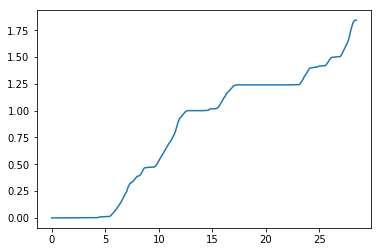

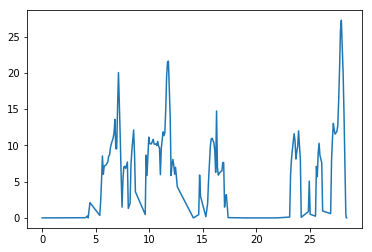

In [166]:
def plot_track(gpx, idx):
    tr = gpx.tracks[idx - 1]
    ts, ds, vs = [0], [0], [0]
    dt, dd, dv = tr.segments
    #
    track_time, track_dist = 0, 0
    cds = [0] # cumulative distance
    for (t, d) in zip(dt, dd):
        track_time += t / 60.0
        track_dist += d
        ts.append(track_time)
        cds.append(track_dist)
    ds.extend(dd)
    vs.extend(dv)
    plt.plot(ts, cds)
    plt.show()
    plt.plot(ts, vs)
    plt.show()

plot_track(gpx, 4)

In [143]:
bad_data = [track.has_bad_timing for track in gpx.tracks]
print sum(bad_data), len(gpx.tracks)

3241 3961


In [179]:
ids = np.array(ids)
ids_bad_data = ids[bad_data]

print ids_bad_data

[   19    23    61 ... 34941 34950 34969]


In [155]:
class Trip:
    
    def __init__(self, trip_id, duration, distance, idle):
        self.id = trip_id
        self.duration = duration
        self.distance = distance
        self.idle = idle
        
    @property
    def aver_velocity(self):
        return 0.0 if self.duration == 0 else 3600.0 * self.distance / self.duration
    
    @property
    def pure_velocity(self):
        return 0.0 if self.duration == 0 or self.duration == self.idle \
                   else 3600.0 * self.distance / (self.duration - self.idle)

In [181]:
import csv

trips = []

with open('sample_all.txt', 'r') as csvfile:
    trips_reader = csv.reader(csvfile, delimiter=',', quotechar='.')
    idx = 0
    for data in trips_reader:
        idx += 1
        trips.append(Trip(idx, float(data[1]), float(data[2]), float(data[4])))
print len(trips)

34969


In [182]:
trips_real = []
dur_zero, dist_zero = 0, 0
for trip in trips:
    if trip.duration == 0:
        dur_zero += 1
    elif trip.distance == 0:
        dist_zero += 1
    else:
        trips_real.append(trip)
trips_real = np.array(trips_real)
print dur_zero, dist_zero, len(trips_real)

40 635 34294


In [161]:
trips_real_good_data = []
for trip in trips_real:
    if not (trip.id in ids_bad_data):
        trips_real_good_data.append(trip)
print len(trips_real_good_data)

31053


10.223542520628419 3.2124078193144094


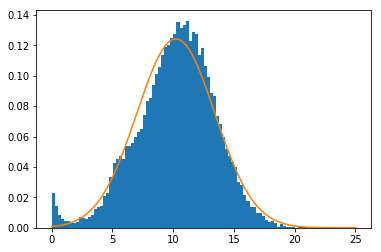

In [198]:
from scipy import stats

vs = np.array([trip.aver_velocity for trip in trips_real_good_data])

m, s = stats.norm.fit(vs)
lnspc = np.linspace(vs.min(), vs.max(), len(vs))
print m, s

plt.hist(vs, bins=100, density=True)
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g)

plt.show()

In [172]:
ds = np.array([trip.distance for trip in trips_real_good_data if trip.distance < 0.1])

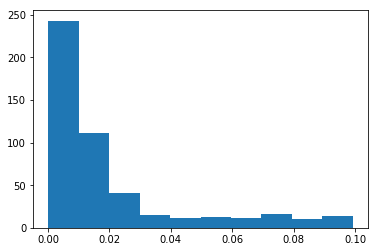

In [173]:
plt.hist(ds)
plt.show()

In [175]:
trips_good_implemented = [trip for trip in trips_real_good_data if trip.distance > 0.05]

10.357469619554806 3.02243310127139


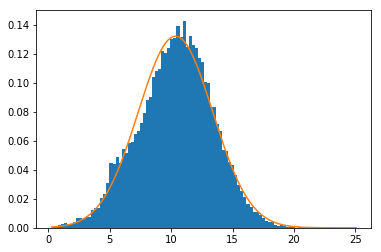

In [197]:
vs = np.array([trip.aver_velocity for trip in trips_good_implemented])

m, s = stats.norm.fit(vs)
lnspc = np.linspace(vs.min(), vs.max(), len(vs))
print m, s

plt.hist(vs, bins=100, density=True)

pdf_gauss = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_gauss, label="normal")

# ag, bg, cg = stats.gamma.fit(vs)  
# pdf_gamma = stats.gamma.pdf(lnspc, ag, bg, cg)  
# plt.plot(lnspc, pdf_gamma, label="gamma")

plt.show()